# Time Series Regression Experiments

In this notebook we will show how to run a simple time series regression experiment using the `tsml-eval` package. Time series regression is the task of predicting a continuous value for a time series.

<img src="./images/TSR.png" width="600" alt="time series regression" style="margin:20px 20px">

In [9]:
import numpy as np
import pandas as pd
from aeon.benchmarking.results_loaders import get_estimator_results
from aeon.datasets import load_regression
from aeon.regression import DummyRegressor
from aeon.visualisation import plot_critical_difference
from sklearn.metrics import mean_squared_error
from tsml.datasets import load_minimal_gas_prices

from tsml_eval.evaluation.storage import load_regressor_results
from tsml_eval.experiments import (
    experiments,
    get_regressor_by_name,
    run_regression_experiment,
)

In [10]:
X_train, y_train = load_minimal_gas_prices(split="train")
X_test, y_test = load_minimal_gas_prices(split="test")

In [11]:
# set_regressor can be used to find various regressors by string, but
# any aeon, tsml or sklearn regressor can be used in the experiments function
regressor = get_regressor_by_name("DummyRegressor")

# record memory usage every 0.1 seconds, just here for notebook speed
# does not need to be changed for usage
experiments.MEMRECORD_INTERVAL = 0.1

run_regression_experiment(
    X_train,
    y_train,
    X_test,
    y_test,
    regressor,
    "./generated_results/",
    dataset_name="GasPrices",
    resample_id=0,
)

A function is also available to load the dataset as well as run an experiment, see `load_and_run_regression_experiment` in `tsml_eval.experiments`.

Both experiment functions will output a results file in the `{results_dir}/{regressor_name}/Predictions/{dataset_name}/` directory. These files can be loaded individually, or used as a collection in the `evaluation` module. See the [evaluation](evaluation.ipynb) notebook for more details.

In [12]:
rr = load_regressor_results(
    "./generated_results/DummyRegressor/Predictions/GasPrices/testResample0.csv"
)
print(rr.predictions)
print(rr.mean_squared_error)
print(rr.root_mean_squared_error)
print(rr.mean_absolute_percentage_error)
print(rr.r2_score)

[-0.32689179 -0.32689179 -0.32689179 -0.32689179 -0.32689179 -0.32689179
 -0.32689179 -0.32689179 -0.32689179 -0.32689179 -0.32689179 -0.32689179
 -0.32689179 -0.32689179 -0.32689179 -0.32689179 -0.32689179 -0.32689179
 -0.32689179 -0.32689179]
0.008893058227437198
0.09430301282269404
0.36624719862013666
-0.07184048625633688


A common use-case is wanting to compare a new algorithm against provided benchmark results. The tsml group stores their publication results and provides an `aeon` function to load them. An example of this is shown below for regression.

In [13]:
reg = DummyRegressor()
datasets = [
    "CardanoSentiment",
    "Covid3Month",
    "FloodModeling1",
    "FloodModeling2",
    "NaturalGasPricesSentiment",
]

# find RMSE for each of our datasets on our estimator
results = {}
for d in datasets:
    train_X, train_y = load_regression(d, split="train")
    test_X, test_y = load_regression(d, split="test")
    reg = reg.fit(train_X, train_y)
    y_pred = reg.predict(test_X)
    results[d] = mean_squared_error(test_y, y_pred, squared=False)

results

{'CardanoSentiment': 0.3002608403259928,
 'Covid3Month': 0.04471992368682529,
 'FloodModeling1': 0.018863328807814914,
 'FloodModeling2': 0.018547996598852055,
 'NaturalGasPricesSentiment': 0.09023204999410936}

In [14]:
benchmarks = ["InceptionT", "FreshPRINCE", "DrCIF"]
res = get_estimator_results(
    datasets=datasets, estimators=benchmarks, task="regression", measure="rmse"
)
res

{'InceptionT': {'CardanoSentiment': 0.3790249345482153,
  'Covid3Month': 0.0547486330011963,
  'FloodModeling1': 0.0066867519847921,
  'FloodModeling2': 0.0043589524619258,
  'NaturalGasPricesSentiment': 0.2406518450482171},
 'FreshPRINCE': {'CardanoSentiment': 0.2894787944853637,
  'Covid3Month': 0.0401913023459625,
  'FloodModeling1': 0.0049994162451307,
  'FloodModeling2': 0.0068567616393676,
  'NaturalGasPricesSentiment': 0.054954074837973},
 'DrCIF': {'CardanoSentiment': 0.3133879847892337,
  'Covid3Month': 0.0430093286336655,
  'FloodModeling1': 0.0060619965978605,
  'FloodModeling2': 0.0061042553512311,
  'NaturalGasPricesSentiment': 0.0534594028311273}}

In [15]:
res["Dummy"] = results
table = pd.DataFrame(res)
table

,InceptionT,FreshPRINCE,DrCIF,Dummy
CardanoSentiment,0.379025,0.289479,0.313388,0.300261
Covid3Month,0.054749,0.040191,0.043009,0.044720
FloodModeling1,0.006687,0.004999,0.006062,0.018863
FloodModeling2,0.004359,0.006857,0.006104,0.018548
NaturalGasPricesSentiment,0.240652,0.054954,0.053459,0.090232


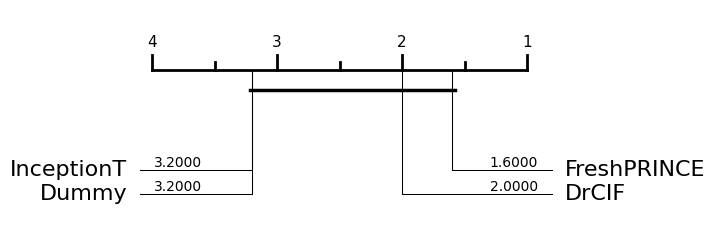

In [16]:
plt, _ = plot_critical_difference(
    np.array(table), list(table.columns), lower_better=True
)
plt.show()